In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
from multiprocessing import Pool

In [7]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Problem 1
*Derive a formula for the overlap area of two circles as a function of their separation and radii. You need the formulae for the area of a triangle in terms of the length of the three sides (Heron’s formula), the law of cosines to derive the angles of intersection, and the area of a sector of a circle in terms of its angle*

<hr>

The general method for coming up with this was to draw a triangle between the centres of the bodies and the top point of intersection. The area of the overlap is found by summing the area of the sector of each body and subtracting the area of the total triangle (this all gives the top half of the overlapping area). The formula is defined as follows (where I assume $r_1 \ge r_2$)
\begin{equation}
    A_{\rm overlap}(a, r_1 ,r_2) = \begin{cases}
                                       \pi r_2^2 & a \le r_1 - r_2 \\
                                       0 & a \ge r_1 + r_2 \\
                                       2 (A_{\rm sec, 1} + A_{\rm sec, 2} - A_{\rm triangle})& \mathrm{else}
                                   \end{cases}
\end{equation}
where from the area of a sector and cosine rule we have
\begin{equation}
    A_{\rm sec, i} = \frac{1}{2} \theta_i r_i^2,\qquad \cos \theta_i = \frac{r_i^2 + a^2 - r_{3 - i}^2}{2 a r_i}
\end{equation}
and from Heron's formula we have that
\begin{equation}
    A_{\rm triangle} = \sqrt{s(s-a)(s-r_1)(s-r_2)},\qquad s = \frac{1}{2} (a + r_1 + r_2)
\end{equation}

This is implemented in `overlap_area(a, r1, r2)`.

In [45]:
def overlap_area_touching(a, r1, r2):
    """Find the overlap area for two circles where `r1 - r2 < a < r1 + r2`

    Parameters
    ----------
    a : `float/array`
        Separations
    r1 : `float`
        Radius of circle 1
    r2 : `float`
        Radius of circle 2

    Returns
    -------
    areas : `float/array`
        Areas of overlap at different separations
    """
    # find the angles using the cosine rule
    theta1 = np.arccos((a**2 + r1**2 - r2**2) / (2 * r1 * a))
    theta2 = np.arccos((a**2 + r2**2 - r1**2) / (2 * r2 * a))

    # use the angles to find the sector areas
    sec1 = 0.5 * theta1 * r1**2
    sec2 = 0.5 * theta2 * r2**2

    # use Heron's formula to get the area of the triangle
    s = 0.5 * (a + r1 + r2)
    triangle = np.sqrt(s * (s - r1) * (s - r2) * (s - a))

    return 2 * (sec1 + sec2 - triangle)


def overlap_area(a, r1, r2):
    """Find the overlap area for two circles of radii `r1` and `r2` at different separations `a`

    Parameters
    ----------
    a : `float/array`
        Separations
    r1 : `float`
        Radius of circle 1
    r2 : `float`
        Radius of circle 2

    Returns
    -------
    areas : `float/array`
        Areas of overlap at different separations
    """
    # set up area array and work out which radius is larger
    areas = np.zeros_like(a)
    r_min = min(r1, r2)
    r_max = max(r1, r2)

    # define lower and upper bounds
    lower = r_max - r_min
    upper = r_max + r_min

    # below the lower bound the area is just the area of the smaller circle
    areas[a < lower] = np.pi * r_min**2

    # above the upper bound the area there is no overlap
    areas[a >= upper] = 0

    # for the area in the range in-between we can use the formula we created
    touching = np.logical_and(a >= lower, a < upper)
    areas[touching] = overlap_area_touching(a[touching], r_max, r_min)

    return areas

Here's a different version that's more useful below. Now it's a function only of $b$ and $k$ and returns the *fraction* of the area covered.

In [93]:
def overlap_area_touching(b, k):
    # find the angles using the cosine rule
    theta1 = np.arccos((b**2 + 1 - k**2) / (2 * b))
    theta2 = np.arccos((b**2 + k**2 - 1) / (2 * b * k))

    # use the angles to find the sector areas
    sec1 = 0.5 * theta1
    sec2 = 0.5 * theta2 * k**2

    # use Heron's formula to get the area of the triangle
    s = 0.5 * (1 + b + k)
    triangle = np.sqrt(s * (s - 1) * (s - k) * (s - b))

    return 2 * (sec1 + sec2 - triangle) / np.pi


def overlap_area(b, k):
    # set up area array and work out which radius is larger
    areas = np.zeros_like(b)

    # below the lower bound the area is just the area of the smaller circle
    areas[b <= 1 - k] = k**2

    # above the upper bound the area there is no overlap
    areas[b >= 1 + k] = 0

    # for the area in the range in-between we can use the formula we created
    touching = np.logical_and(b > 1 - k, b < 1 + k)
    areas[touching] = overlap_area_touching(b[touching], k)

    return areas

# Problem 2
*Write a function to compute the transit/secondary eclipse of a body **without limb-darkening***
<hr>

In [95]:
def lightcurve(t, t0, b0, v, k, P, flux):
    t_fold = t % P
    b = np.sqrt(b0**2 + (v * (t_fold - t0))**2)
    return flux * (1 - overlap_area(b, k))

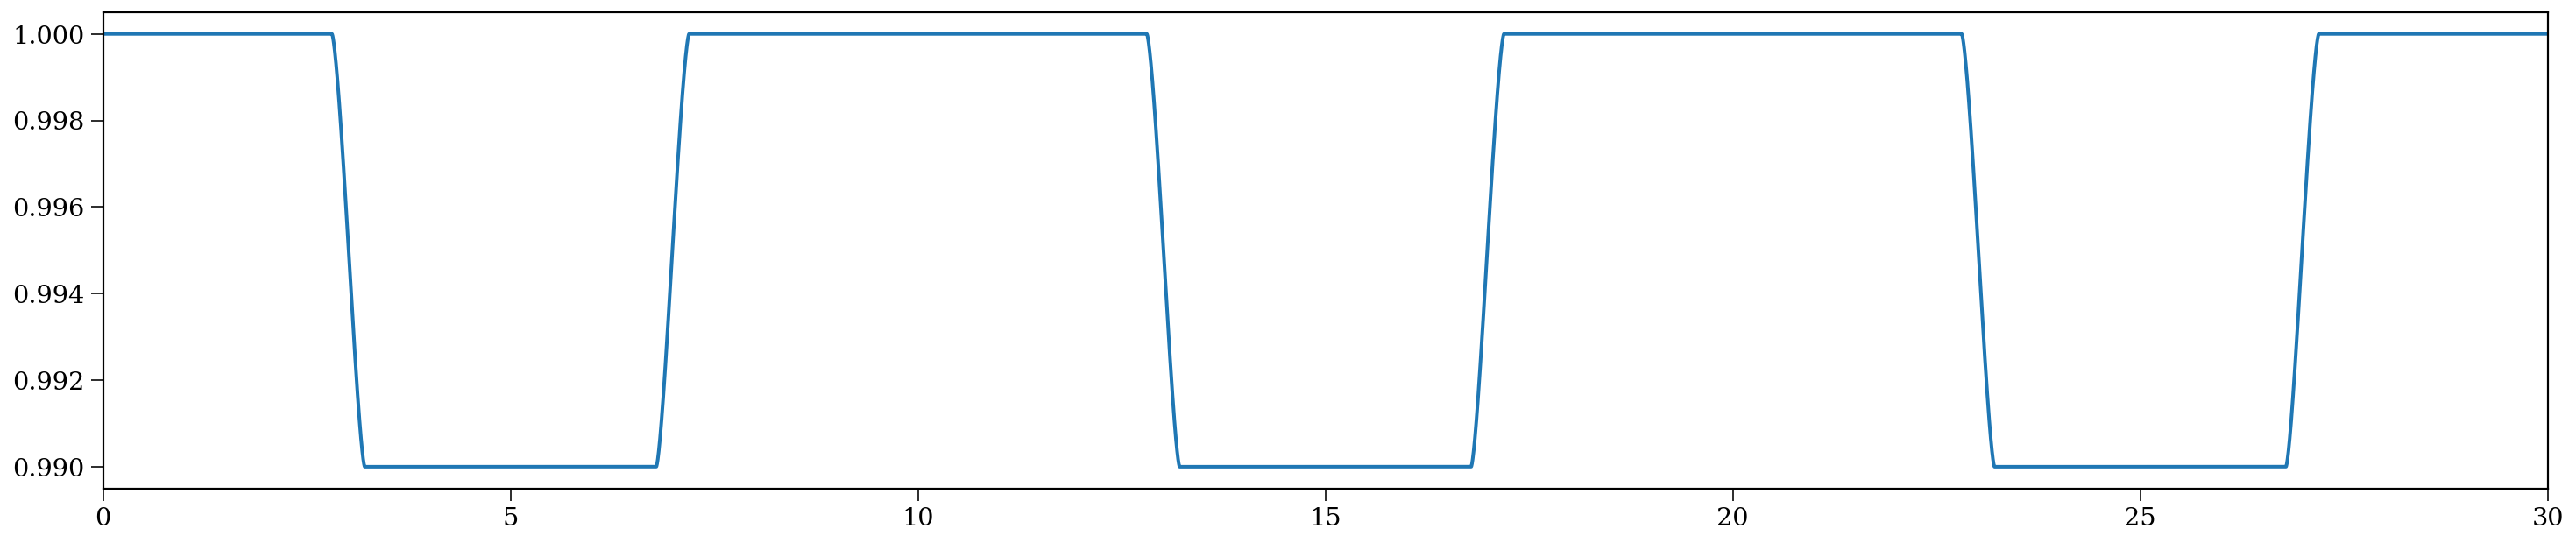

In [232]:
fig, ax = plt.subplots(figsize=(25, 5))

t_range = np.linspace(0, 30, 10000)
flux = lightcurve(t_range, t0=5, b0=0.1, v=0.5, k=0.1, P=10, flux=1)

plt.plot(t_range, flux, lw=2)

ax.set_xlim(t_range.min(), t_range.max())

plt.show()

# Problem 3
*Using layer-cake prescription, call uniform transit code multiple times to produce a limb-darkened transit with arbitrary limb-darkening profile (see ‘batman’ Kreidberg 2015)*

In [229]:
def quadratic_limb_darkening(r, u1, u2):
    mu = np.zeros_like(r)
    mu[r**2 <= 1] = np.sqrt(1 - r[r**2 <= 1]**2)
    return 1 - u1 * (1 - mu) - u2 * (1 - mu)**2

In [230]:
def limb_darkened_lightcurve(t, t0, b0, v, k, P, flux, u1=None, u2=None, profile=None):
    if (u1 is None or u2 is None) and profile is None:
        raise ValueError("Either specifiy both u1 and u2 or a profile function")
    
    t_fold = t % P
    r = v * (t_fold - t0)
    b = np.sqrt(b0**2 + r**2)
    
    if profile is None:
        limbs = quadratic_limb_darkening(r, u1, u2)
    else:
        limbs = profile(r)

    return flux * (1 - overlap_area(b, k) * limbs)

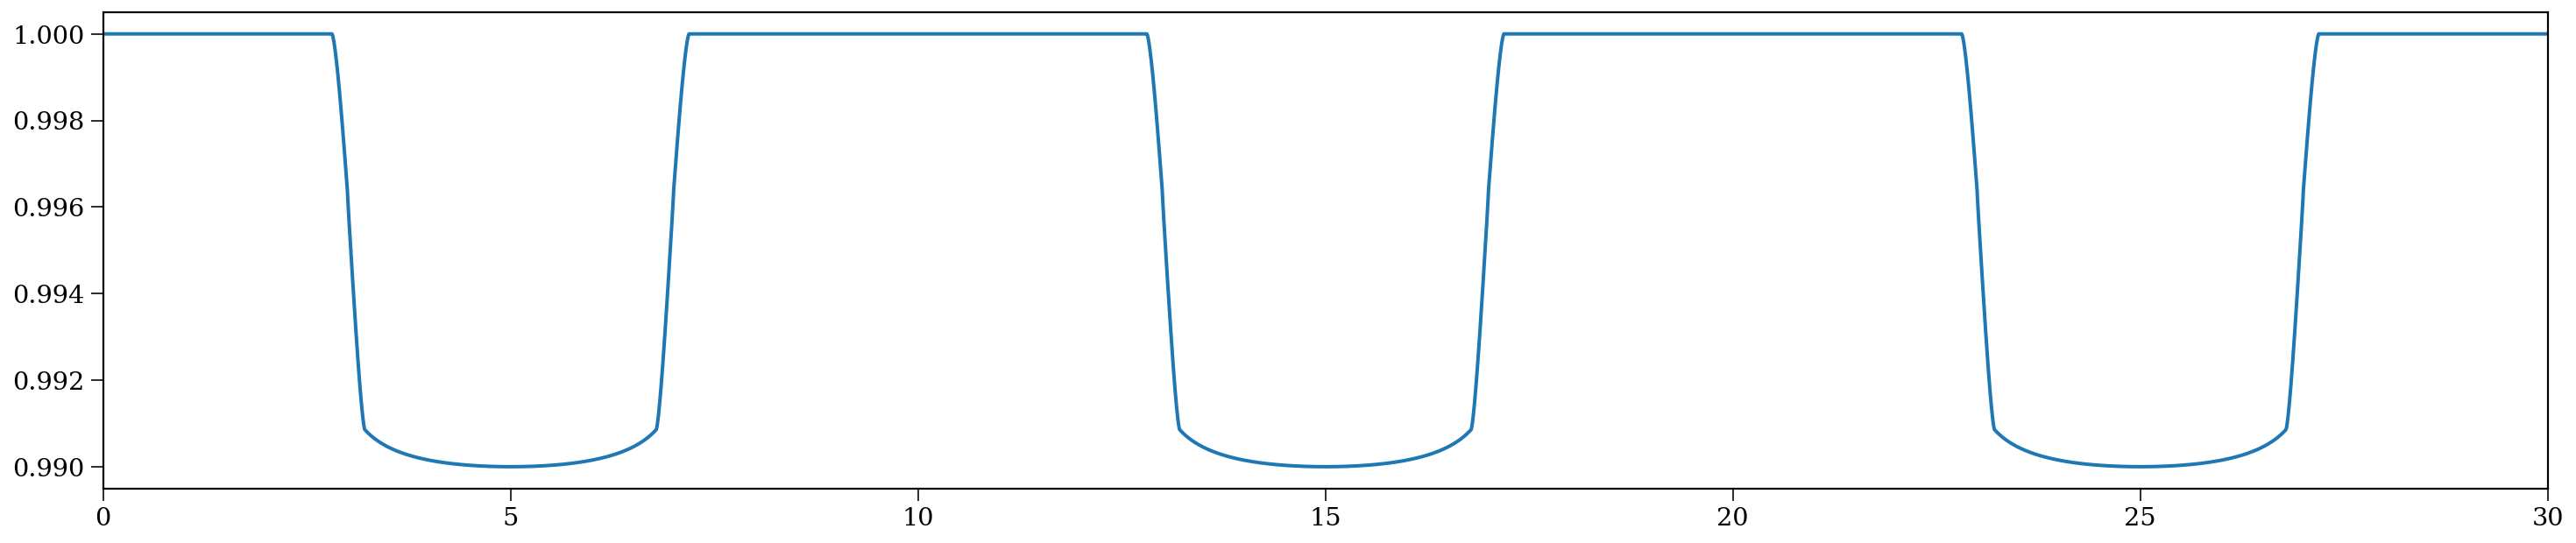

In [231]:
fig, ax = plt.subplots(figsize=(25, 5))

t_range = np.linspace(0, 30, 10000)
flux = limb_darkened_lightcurve(t_range, t0=5, b0=0.1, v=0.5, k=0.1, P=10, flux=1, u1=0.1, u2=0.1)

plt.plot(t_range, flux, lw=2)

ax.set_xlim(t_range.min(), t_range.max())

plt.show()

# Problem 4
*Use your model to fit the data ‘mystery_planet02.txt‘ (note: if you are unsure of the orbital period, try smoothing the data and/or using the periodogram used in the first homework). What is the orbital period in days? What is the depth, impact parameter, and duration of this transiting body? What is the density of the star?*

In [241]:
smoothing_window = 5

planet = pd.read_csv("mystery_planet02.txt", delim_whitespace=True, names=["time", "I", "I_err"])
planet["I"] = planet["I"].rolling(smoothing_window).mean()
planet["I_err"] = planet["I_err"].rolling(smoothing_window).mean()
planet.dropna(inplace=True)

### Find the period

In [244]:
period_range = np.linspace(0.01, 15, 10000)
least_squares = np.zeros_like(period_range)

# loop over each period
for i, period in enumerate(period_range):
    # folder the data on this period
    planet["folded_time"] = planet["time"].values % period

    # sort the data by new folded times
    planet.sort_values("folded_time", inplace=True)

    # calculate the sum of the squares for this period
    least_squares[i] = np.sum((planet["I"].diff())**2)

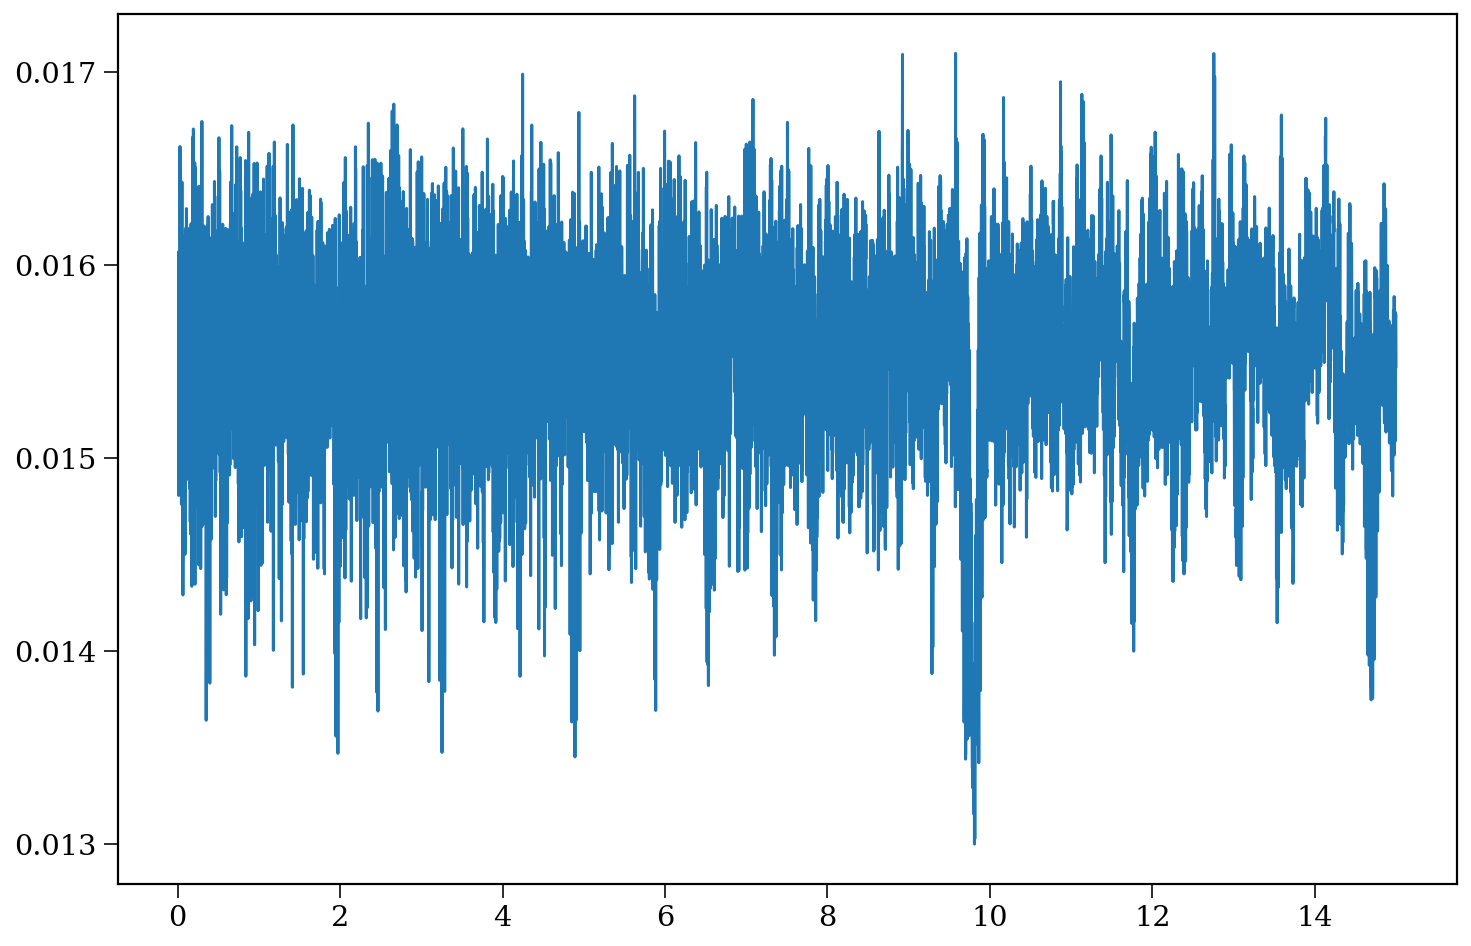

In [245]:
plt.plot(period_range, least_squares)

### Plot phase folded light curve

In [249]:
best_period = period_range[least_squares.argmin()]
planet["folded_time"] = planet["time"].values % best_period
planet.sort_values("folded_time", inplace=True)
best_period

9.80994299429943

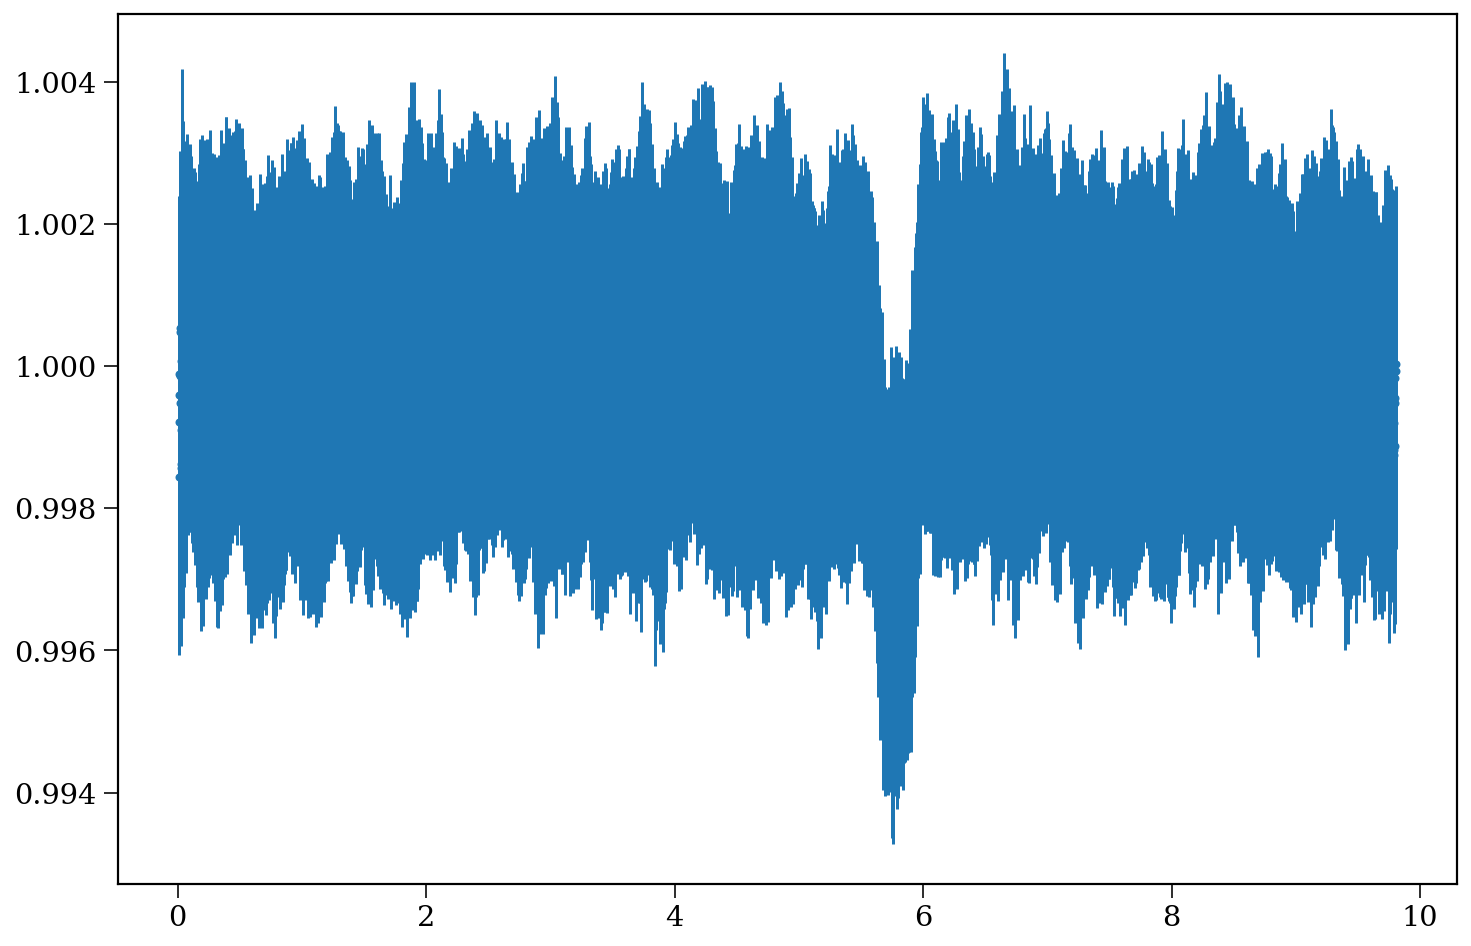

In [251]:
window = 5
plt.errorbar(x=planet["folded_time"], y=planet["I"].rolling(window).mean(), yerr=planet["I_err"].rolling(window).mean(), marker="o", markersize=3, ls="none")
plt.show()

### Use `emcee` to fit the parameters

In [254]:
def log_prior(theta, bounds):
    for i in range(len(bounds)):
        if theta[i] < bounds[i][0] or theta[i] >= bounds[i][1]:
            return -np.inf
    return 0.0


def log_likelihood(theta, data_times, data_I, data_I_err):
    t0, b0, v, k, P, u1, u2 = theta
    model_lightcurve = limb_darkened_lightcurve(t=data_times, flux=1, t0=t0, b0=b0, v=v, k=k, P=P, u1=u1, u2=u2)

    sigma2 = data_I_err**2
    return -0.5 * np.sum((data_I - model_lightcurve)**2 / sigma2 + np.log(sigma2))


def log_prob(theta, data_times, data_I, data_I_err, bounds):
    prior = log_prior(theta, bounds)
    if not np.isfinite(prior):
        return prior
    else:
        return log_likelihood(theta, data_times, data_I, data_I_err) + prior

In [255]:
bounds = [(0, best_period), (0, 1), (0, 2), (0, 1), (best_period - 0.2, best_period + 0.2), (0, 1), (0, 1)]
initial_guesses = [5.8, 0.1, 0.1, 0.01, best_period, 0.1, 0.1]

In [262]:
reload(emcee)
emcee.__version__

'2.2.1'

In [259]:
n_walkers = 16
steps = 1000
perturbation = 1e-4
pos = initial_guesses + perturbation * np.random.randn(n_walkers, len(initial_guesses))

# use a multiprocessing pool to speed things up
with Pool() as pool:
    # instantiate a sampler
    sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=len(initial_guesses), log_prob_fn=log_prob,
                                    args=(planet["time"].values, planet["I"].values, planet["I_err"].values, bounds),
                                    pool=pool)

    # run the MCMC with a progress bar
    _ = sampler.run_mcmc(pos, steps, progress=True)

# get the samples and the best fit
samples = sampler.get_chain(discard=burn_in, flat=True)
best_fit = np.median(samples, axis=0)

TypeError: __init__() got an unexpected keyword argument 'ndim'